In [3]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import mlflow

# define the sys.path for importing the load_preprocess_data function
sys.path.append("..")

# import our function for pre-processing the raw data for the selected hard drive
from src.data.preprocessing import load_preprocess_data
from src.data.preprocessing import train_test_splitter
from src.features.feature_engineering import create_features


from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix, f1_score, fbeta_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import make_scorer, precision_recall_curve, mean_squared_error

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# set the plotting styel for the notebook
plt.style.use('classic')

# define the random seed for modelling and train-test split
RSEED = 42

/Users/danielamueller/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
# use the load_preprocess_data function to pre-process the raw data and load it into a pandas data frame
repo_path = os.getcwd()+"/../"
df = load_preprocess_data(path=repo_path)
df.shape

(462966, 43)

In [5]:
df = create_features(df, interval=30, trigger_percentage=0.05)
df.shape

100%|██████████| 608/608 [00:26<00:00, 23.02it/s]


(462966, 66)

In [6]:
# Remove countdowns over 800
df = df[df.countdown <= 800]
print("Shape after removal of large countdowns:", df.shape)

# Remove smart_7_raw outliers
sn_to_drop = df[df.smart_7_raw > 5e10].serial_number.unique()
for sn in sn_to_drop:
    df.drop(df[df.serial_number == sn].index, inplace=True)
print("Shape after removal of smart_7_raw outlier:", df.shape)

Shape after removal of large countdowns: (418172, 66)
Shape after removal of smart_7_raw outlier: (416073, 66)


In [7]:
def create_train_test_split(df, feats, days=30, test_size=0.3, random_state=42):

    X = df[feats]
    y = create_target(df, days=days)

    X_train, X_test, y_train, y_test = train_test_splitter(X, y, test_size=test_size, random_state=random_state)

    serial_number = X_test.serial_number
    date = X_test.date

    X_train.drop('serial_number', axis=1, inplace=True)
    X_test.drop('serial_number', axis=1, inplace=True)

    X_train.drop('date', axis=1, inplace=True)
    X_test.drop('date', axis=1, inplace=True)

    return X_train, X_test, y_train, y_test, serial_number, date

In [8]:
def create_add_feature(df, columns, rolling_window=50):
      
    df['new'] = 0

    for col in columns:
        df['new'] += df[col]

    df.sort_values(['serial_number', 'date'], ascending=True, inplace=True)

    f = lambda x: x.rolling(rolling_window).mean()
    df['new_rolling'] = df.groupby('serial_number').new.apply(f)

    df.dropna(axis=0, inplace=True)
    df.drop('new', axis=1, inplace=True)

    return df

In [9]:
def create_rma_feature(df, columns, rolling_window=25):

    df.sort_values(['serial_number', 'date'], ascending=True, inplace=True)

    f = lambda x: x.rolling(rolling_window).mean()

    for col in columns:
          df[f'{col}_rma'] = df.groupby('serial_number')[col].apply(f)

    df.dropna(axis=0, inplace=True)

    return df

In [10]:
def normalize_data(X_train, X_test, type=MinMaxScaler):
    scaler = type()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test

In [11]:
def logtransform_data(X_train, X_test):
    X_train = np.log(X_train+1)
    X_test = np.log(X_test+1)

    return X_train, X_test

In [12]:
def create_target(df, days=30):
    return df.countdown <= days

In [13]:
def train_eval_model(model, X_train, X_test, y_train, y_test):
        """Train the model, make predictions and evaluate the model

        Args:
            model (_type_): Model including hyperparameters
            X_train (_type_): X_train
            X_test (_type_): X_test
            y_train (_type_): y_train
            y_test (_type_): y_test

        Returns:
            _type_: Fitted model, predictions and probabilities
        """
        print("Fitting")
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        y_train_proba = model.predict_proba(X_train)
        y_proba = model.predict_proba(X_test)
        fbeta_test = fbeta_score(y_test, y_pred, beta=2).round(2)
        auc_test = roc_auc_score(y_test, y_proba[:,1]).round(2)
        recall_test = recall_score(y_test, y_pred).round(2)
        fbeta_train = fbeta_score(y_train, y_train_pred, beta=2).round(2)
        auc_train = roc_auc_score(y_train, y_train_proba[:,1]).round(2)
        recall_train = recall_score(y_train, y_train_pred).round(2)
        print("---------------------------------------------------")
        print("Model evaluation")
        print("F2 score test (train):", fbeta_test, "(", fbeta_train, ")")
        print("Area under the ROC curve test (train):", auc_test, "(", auc_train, ")")
        print("Recall test (train):", recall_test, "(", recall_train, ")")
        return model, y_pred, y_proba[:,1]

In [14]:
def predict_threshold(y_pred_proba, threshold=0.5):
        """Make predictions based on a threshold

        Args:
            y_pred_proba (_type_): Predicted probabilities
            threshold (float, optional): Theshold. Defaults to 0.5.

        Returns:
            _type_: _description_
        """
        return y_pred_proba > threshold

In [15]:
def plot_pr_curve(y_test, y_pred_proba):
        """Plot the precision recall curve and the f2 curve

        Args:
            y_test (_type_): Predictions
            y_pred_proba (_type_): Predicted probabilities

        Returns:
            _type_: F2 scores and the threshold of maximum F2
        """

        pre, rec, thresholds1 = precision_recall_curve(y_test, y_pred_proba)
        f2 = (5)*(pre*rec)/(4*pre + rec)
        plt.plot(thresholds1, pre[1:],'r-',label = 'Precision Model')
        plt.plot(thresholds1, rec[1:],'b-',label = 'Recall Model')
        plt.plot(thresholds1, f2[1:],'g-',label = 'f2 Model')
        plt.legend()
        plt.xlabel('Threshold')
        plt.ylabel('Metrics')
        plt.show()
        idx = np.nanargmax(f2)
        return f2, thresholds1[idx]

In [16]:
def eval_model(y_true, y_pred, y_proba):
        """Calculate the scores of the model

        Args:
            y_true (_type_): True labels
            y_pred (_type_): Predicted labels
            y_proba (_type_): Predicted probabilities
        """
        fbeta_test = fbeta_score(y_true, y_pred, beta=2).round(2)
        auc_test = roc_auc_score(y_true, y_proba).round(2)
        recall_test = recall_score(y_true, y_pred).round(2)
        print("F2 score test:", fbeta_test)
        print("Area under the ROC curve test:", auc_test)
        print("Recall test:", recall_test)
        return

In [17]:
def xgb_scorer(predt, dtrain):
    y = dtrain.get_label()
    predt = (predt > threshold)
    return 'f2', fbeta_score(y, predt, beta=2)

ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [18]:
columns = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999']

In [19]:
df = create_rma_feature(df, columns, rolling_window=25)
df.head()

,date,serial_number,model,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,...,smart_192_raw_rma,smart_193_raw_rma,smart_194_raw_rma,smart_197_raw_rma,smart_198_raw_rma,smart_199_raw_rma,smart_240_raw_rma,smart_241_raw_rma,smart_242_raw_rma,smart_999_rma
198955,2019-04-28,S300VKL9,ST4000DM000,0,92662064.0,7.0,0.0,571444604.0,32834.0,5.0,...,0.0,47214.0,30.40,0.0,0.0,0.0,32286.44,4.997021e+10,1.413294e+11,0.0
201380,2019-04-29,S300VKL9,ST4000DM000,0,24677144.0,7.0,0.0,571868184.0,32858.0,5.0,...,0.0,47214.0,30.36,0.0,0.0,0.0,32310.76,4.997301e+10,1.414741e+11,0.0
230523,2019-04-30,S300VKL9,ST4000DM000,0,236961792.0,7.0,0.0,572318630.0,32882.0,5.0,...,0.0,47214.0,30.32,0.0,0.0,0.0,32335.08,4.997587e+10,1.416200e+11,0.0
224449,2019-05-01,S300VKL9,ST4000DM000,0,40555736.0,7.0,0.0,572514352.0,32894.0,5.0,...,0.0,47214.0,30.40,0.0,0.0,0.0,32358.96,4.997868e+10,1.417641e+11,0.0
221413,2019-05-02,S300VKL9,ST4000DM000,0,24526080.0,7.0,0.0,573704676.0,32918.0,5.0,...,0.0,47214.0,30.40,0.0,0.0,0.0,32382.84,4.998154e+10,1.419110e+11,0.0


In [20]:
columns = []

for col in df.columns:
    if '242' in col or '241' in col or '240' in col or '_9_' in col:
        columns.append(col)

df = create_add_feature(df, columns, rolling_window=25)

In [21]:
feats = ['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'new_rolling',
       'smart_999', 
       'date','serial_number']

In [22]:
X_train, X_test, y_train, y_test, serial_number, date = create_train_test_split(df, feats, random_state=42, test_size=0.3)
columns = X_train.columns.to_list()

In [23]:
X_test.shape

(115942, 22)

In [24]:
X_train, X_test = logtransform_data(X_train, X_test)
X_train, X_test = normalize_data(X_train, X_test)

In [25]:
model = XGBClassifier(  scale_pos_weight=len(y_train)/y_train.sum(), # ratio of number of negative class to the positive class
                        colsample_bytree=0.5, # 1, Number of features used by tree, lower to regularize
                        subsample=0.2, # 1, ratio of the training instances used, lower to regularize
                        eta=0.05, # 0.3, learning rate, lower values to regularize
                        gamma=0, # 0, regularization parameter, higher to regularize
                        max_depth=6, # 6, maximum tree depth
                        alpha=1,
                        #reg_lambda=0.2,
                        #n_estimators=100,
                        #n_estimators= , #
                        min_child_weight=2 , # 1, minimum sum of instance weight needed in a leaf, higher to regularize
                        #lambda=1, # L2 regularization
                        #early_stopping_rounds = 50,
                        use_label_encoder=False, verbosity=0,
                                                )

Fitting
---------------------------------------------------
Model evaluation
F2 score test (train): 0.39 ( 0.59 )
Area under the ROC curve test (train): 0.83 ( 0.95 )
Recall test (train): 0.64 ( 0.89 )


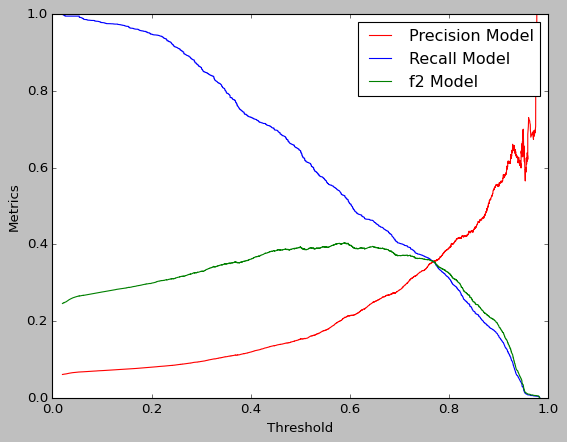

In [26]:
# Fit and evaluate the model
model, y_pred, y_proba = train_eval_model(model, X_train, X_test, y_train, y_test)
_, threshold = plot_pr_curve(y_test, y_proba)

In [27]:
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

F2 score test: 0.4
Area under the ROC curve test: 0.83
Recall test: 0.52


In [28]:
test_data = pd.concat([pd.Series(serial_number, name='serial_number').reset_index(drop=True),pd.Series(date, name='date').reset_index(drop=True),  pd.DataFrame(X_test, columns=columns).reset_index(drop=True), pd.Series(y_test, name='true').reset_index(drop=True), pd.Series(y_pred_t, name='prediction').reset_index(drop=True)], axis=1)
test_data.shape

(115942, 26)

In [29]:
error = test_data.query('true != prediction')
error.serial_number.value_counts().head()


Z303KKKN    344
S301GS51    308
Z304JW7X    295
S300ZP7C    285
Z302SZHJ    268
Name: serial_number, dtype: int64

In [30]:
serial = 'Z305D6ZM'

check = error[error['serial_number'] == serial]

smart_columns = []
    
for col in check.columns:
    if 'smart' in col:
        smart_columns.append(col)

In [31]:
check.tail(50)

,serial_number,date,smart_4_raw,smart_5_raw,smart_7_mod,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,...,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,new_rolling,smart_999,true,prediction
103737,Z305D6ZM,2021-07-22,0.43483,0.557231,0.571189,0.871592,0.398668,0.210663,0.0,0.736595,...,0.509666,0.509666,0.0,0.872274,0.880178,0.489724,0.515987,0.815465,False,True
103738,Z305D6ZM,2021-07-23,0.43483,0.558719,0.571272,0.871939,0.398668,0.210663,0.0,0.738468,...,0.509666,0.509666,0.0,0.872607,0.880302,0.490120,0.516257,0.630930,False,True
103739,Z305D6ZM,2021-07-24,0.43483,0.558719,0.571470,0.872285,0.398668,0.210663,0.0,0.740316,...,0.509666,0.509666,0.0,0.872955,0.880464,0.490584,0.516532,0.630930,False,True
103740,Z305D6ZM,2021-07-25,0.43483,0.567168,0.571774,0.872631,0.398668,0.210663,0.0,0.744838,...,0.504554,0.504554,0.0,0.873303,0.880631,0.490987,0.516812,0.630930,False,True
103741,Z305D6ZM,2021-07-26,0.43483,0.568502,0.572035,0.872963,0.398668,0.210663,0.0,0.745726,...,0.509666,0.509666,0.0,0.873650,0.880813,0.491242,0.517087,0.500000,False,True
103742,Z305D6ZM,2021-07-27,0.43483,0.568502,0.572227,0.873309,0.398668,0.210663,0.0,0.745726,...,0.509666,0.509666,0.0,0.873983,0.880953,0.491404,0.517366,0.500000,False,True
103743,Z305D6ZM,2021-07-28,0.43483,0.568502,0.572442,0.873827,0.398668,0.210663,0.0,0.746609,...,0.509666,0.509666,0.0,0.874504,0.881180,0.491804,0.517647,0.500000,False,True
103744,Z305D6ZM,2021-07-29,0.43483,0.568502,0.572562,0.874159,0.398668,0.210663,0.0,0.747486,...,0.509666,0.509666,0.0,0.874836,0.881330,0.492077,0.517928,0.500000,False,True
103745,Z305D6ZM,2021-07-30,0.43483,0.568502,0.572693,0.874489,0.398668,0.210663,0.0,0.747486,...,0.509666,0.509666,0.0,0.875183,0.881540,0.492363,0.518209,0.500000,False,True
103746,Z305D6ZM,2021-07-31,0.43483,0.568502,0.572881,0.874835,0.398668,0.210663,0.0,0.747486,...,0.509666,0.509666,0.0,0.875515,0.881732,0.492570,0.518491,0.500000,False,True


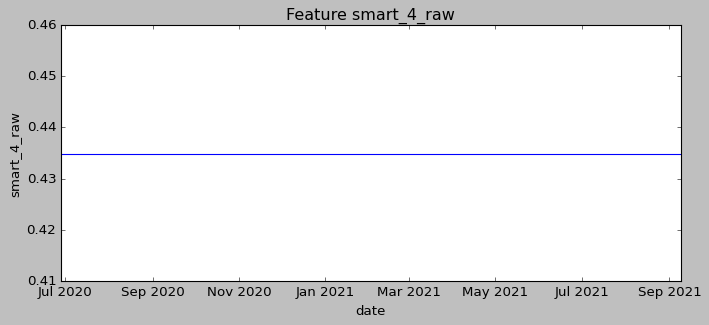

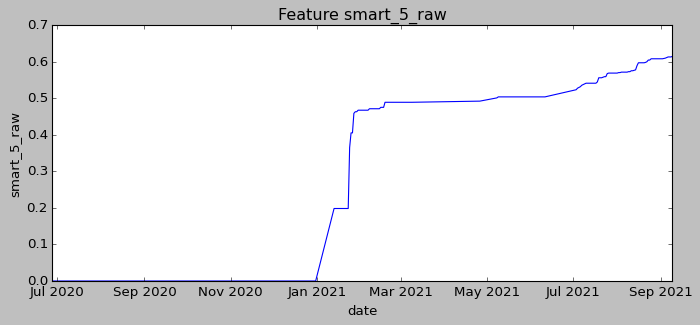

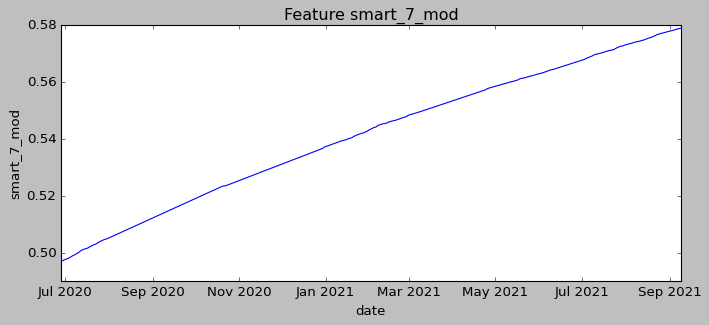

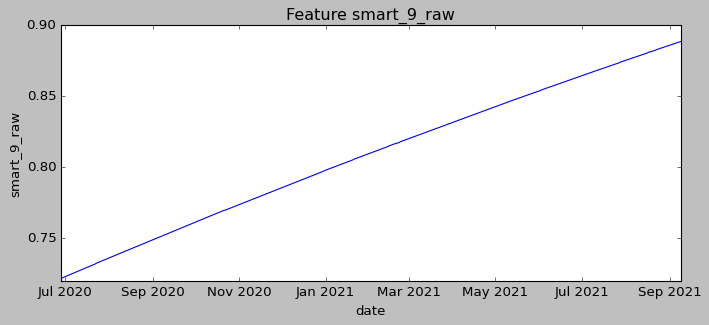

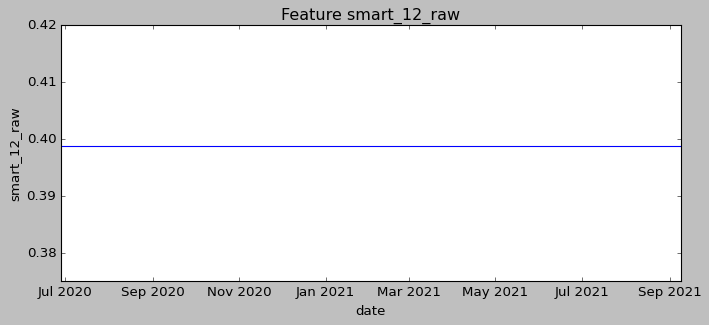

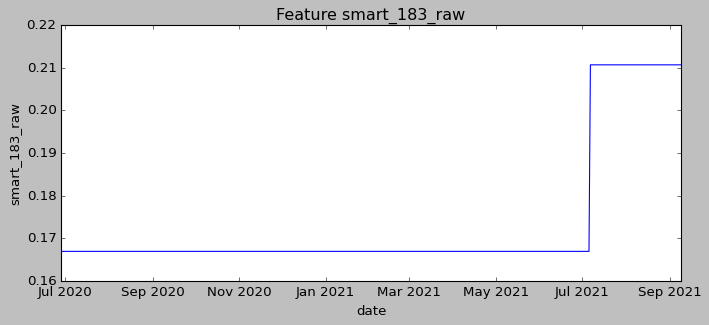

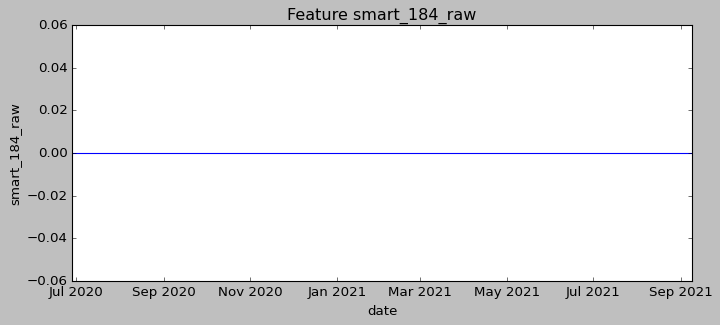

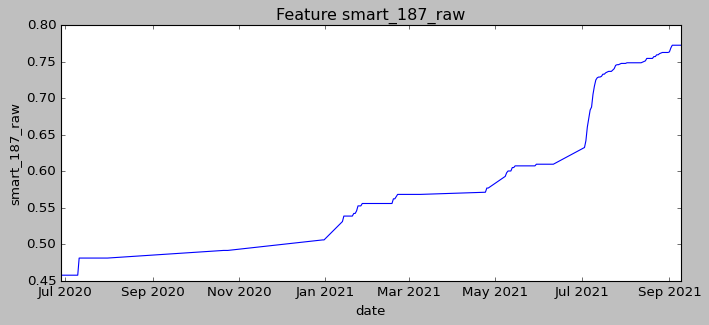

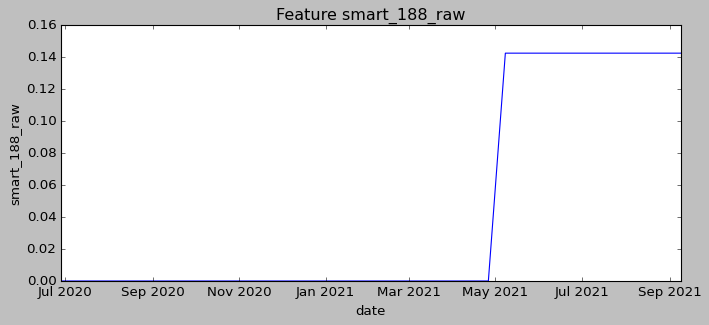

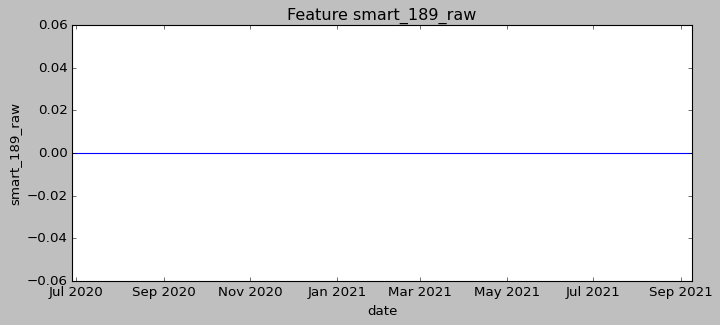

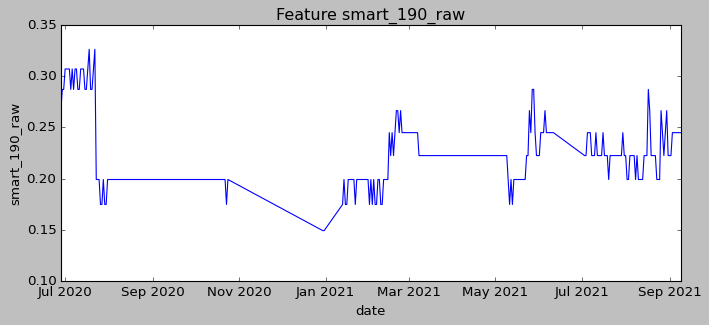

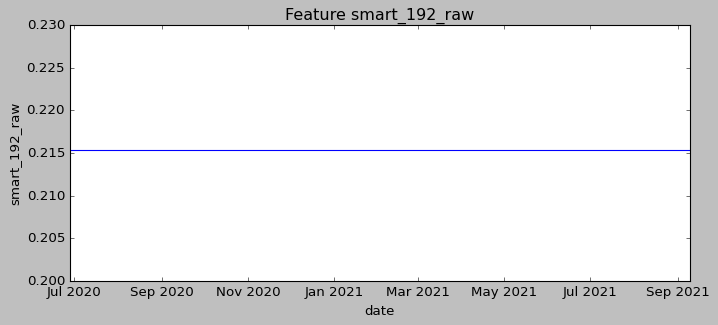

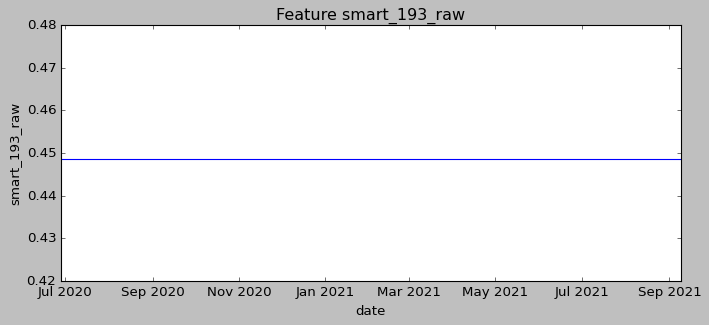

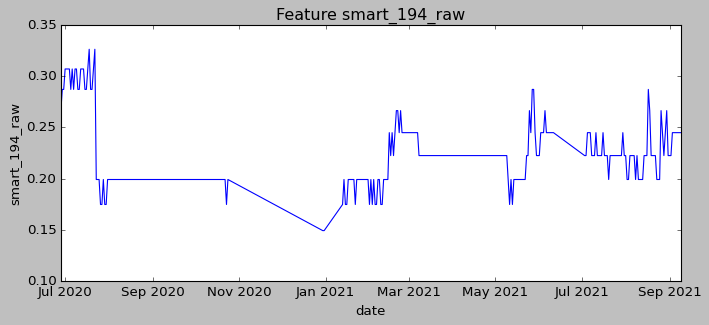

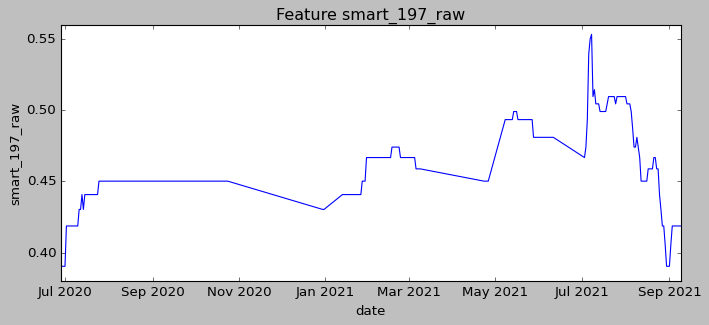

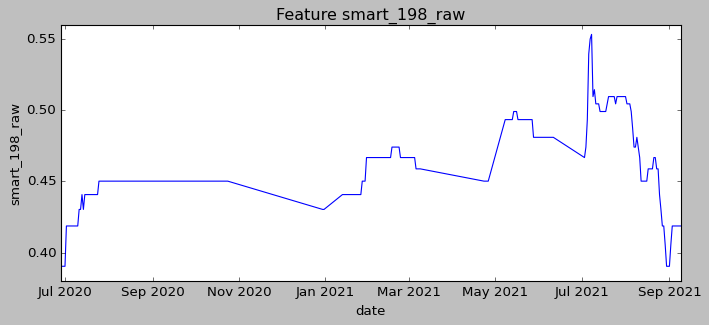

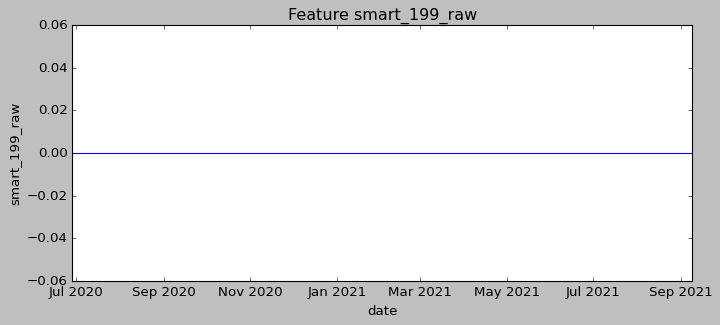

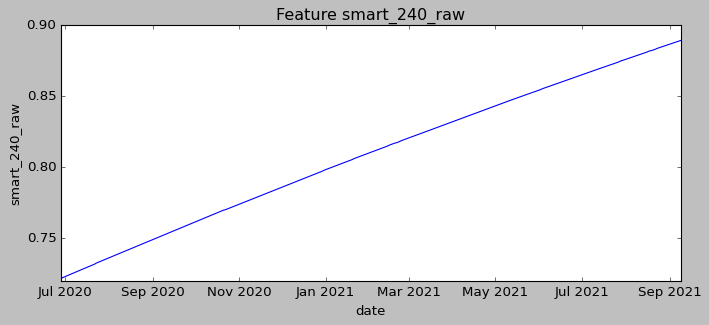

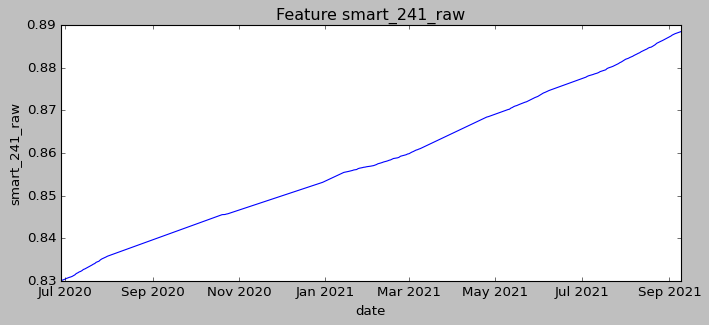

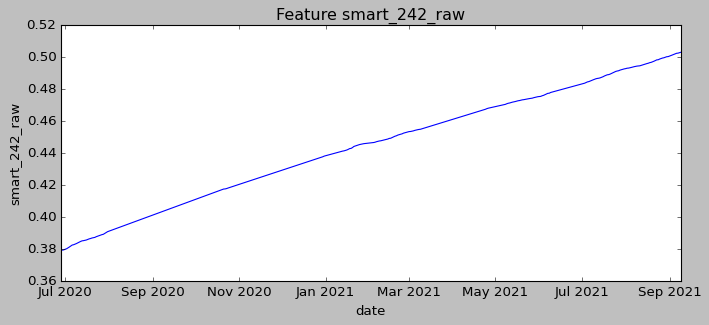

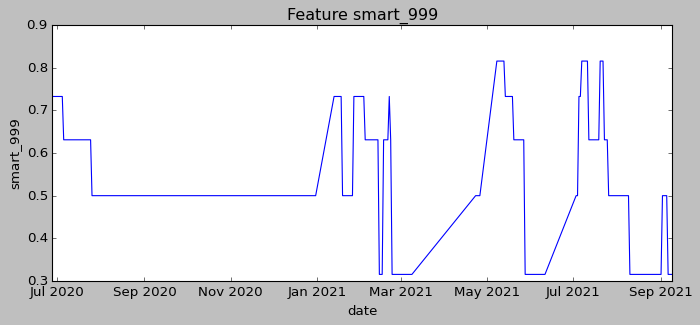

In [32]:
for col in smart_columns:
    plt.subplots(1, 1, figsize=(10, 4))
    g = sns.lineplot(x=check.date, y=check[col])
    g.set_title(f'Feature {col}');